**Télécharger le dataset**

In [131]:
import pandas as pd

df = pd.read_csv('cinema_data.csv')
print(df.head(15))

print(df.info())

print(df['sentiment'].value_counts())


                                               review sentiment
0   One of the other reviewers has mentioned that ...  positive
1   A wonderful little production. <br /><br />The...  positive
2   I thought this was a wonderful way to spend ti...  positive
3   Basically there's a family where a little boy ...  negative
4   Petter Mattei's "Love in the Time of Money" is...  positive
5   Probably my all-time favorite movie, a story o...  positive
6   I sure would like to see a resurrection of a u...  positive
7   This show was an amazing, fresh & innovative i...  negative
8   Encouraged by the positive comments about this...  negative
9   If you like original gut wrenching laughter yo...  positive
10  Phil the Alien is one of those quirky films wh...  negative
11  I saw this movie when I was about 12 when it c...  negative
12  So im not a big fan of Boll's work but then ag...  negative
13  The cast played Shakespeare.<br /><br />Shakes...  negative
14  This a fantastic movie of three pris

**Pré-processing**

In [132]:
import spacy
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd

nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm') 
nltk_stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.lower()
    return text

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in nltk_stopwords]
    return ' '.join(tokens)

def preprocess_reviews(reviews):
    cleaned_reviews = [clean_text(review) for review in reviews]
    
    docs = nlp.pipe(cleaned_reviews, batch_size=500)
    processed_reviews = [' '.join([token.lemma_ for token in doc if token.is_alpha and token.text not in nltk_stopwords]) for doc in docs]
    
    return processed_reviews

df = pd.read_csv('cinema_data.csv')

df['cleaned_review'] = preprocess_reviews(df['review'])

print(df[['review', 'cleaned_review']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clementgranjou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewer mention watch oz episode hook rig...  
1  wonderful little production br br filming tech...  
2  think wonderful way spend time hot summer week...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


**Vectorisation**

In [147]:

df.head()
df.columns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer(max_features=10000)
X_count = count_vectorizer.fit_transform(df['cleaned_review'])

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])

print(f'Count Vectorizer shape: {X_count.shape}')
print(f'TF-IDF Vectorizer shape: {X_tfidf.shape}')




Count Vectorizer shape: (50000, 5000)
TF-IDF Vectorizer shape: (50000, 10000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Nuage de mots**

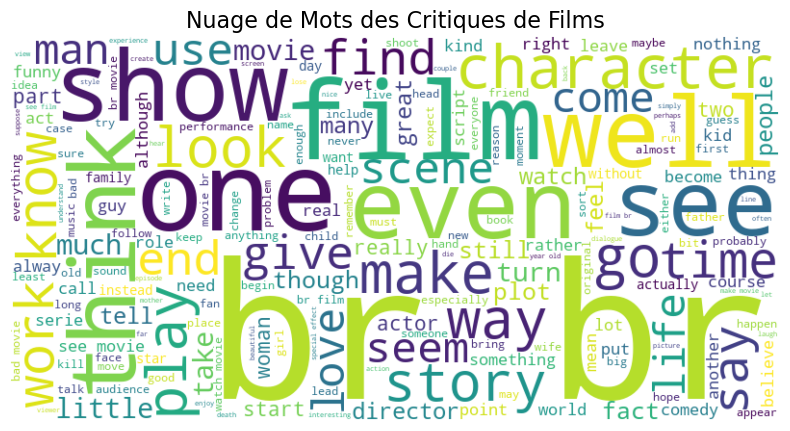

In [148]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots des Critiques de Films', fontsize=16)
plt.show()


**Division des données**

In [149]:
from sklearn.model_selection import train_test_split

y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')


Train set shape: (45000, 10000), Test set shape: (5000, 10000)


**Modèle Multinomial Naïve Bayes**

In [150]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8558


**Évaluation du modèle**

In [151]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      2481
    positive       0.85      0.86      0.86      2519

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Confusion Matrix:
[[2106  375]
 [ 346 2173]]


In [152]:
new_reviews = ["The film was horrible!",
    "I found the movie dull and uninteresting."]



cleaned_new_reviews = preprocess_reviews(new_reviews)

X_new = tfidf_vectorizer.transform(cleaned_new_reviews)

new_predictions = nb_model.predict(X_new)

# Afficher les prédictions
for review, sentiment in zip(new_reviews, new_predictions):
    print(f'Review: {review} -> Sentiment: {"Positive" if sentiment == 1 else "Negative"}')


Review: The film was absolutely fantastic and very entertaining! -> Sentiment: Negative
Review: I found the movie dull and uninteresting. -> Sentiment: Negative
